# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

In [2]:
# Carregar os datasets

transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=128)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=128)

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        layers = {
            'c1': 120,
            'c2': 32,
            'l1': 50,
        }
        
        self.layers = layers
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(3, layers['c1'], 5)
        self.batchnorm1 = nn.BatchNorm2d(layers['c1'])
        self.conv2 = nn.Conv2d(layers['c1'], layers['c2'], 5)
        self.batchnorm1 = nn.BatchNorm2d(layers['c2'])
        self.fc1 = nn.Linear(layers['c2'] * 5 * 5, layers['l1'])
        self.fc2 = nn.Linear(layers['l1'], 10)
        self.activation_function = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.activation_function(self.conv1(x)))
        x = self.pool(self.activation_function(self.conv2(x)))
        x = x.view(-1, self.layers['c2'] * 5 * 5)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN()
model.to(device)

print(model)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 120, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(120, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (activation_function): ReLU()
)


In [0]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
loss_fn = torch.nn.CrossEntropyLoss()


In [0]:
def train(epochs):
    losses = []
    for epoch in range(epochs):
        print('Epoch ' + str(epoch + 1) + ':')
            
        correct = 0
        total = 0
        
        running_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
              inputs, labels = inputs.to(device), labels.to(device)

              optimizer.zero_grad()

              outputs = model(inputs)
              loss = loss_fn(outputs, labels)
              loss.backward()
              optimizer.step()

              _, pred = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (pred == labels).sum().item()

              running_loss += loss.item()
              
              if i % 1999 == 0:
                losses.append(running_loss/2000)
                running_loss = 0.0

                
        print('  Training accuracy: %d %%' % (
            100 * correct / total))
    
            
    plt.plot(losses)
    plt.title("Loss")
    plt.show()
            


Epoch 1:
  Training accuracy: 10 %
Epoch 2:
  Training accuracy: 10 %
Epoch 3:
  Training accuracy: 10 %
Epoch 4:
  Training accuracy: 10 %
Epoch 5:
  Training accuracy: 10 %
Epoch 6:
  Training accuracy: 10 %
Epoch 7:
  Training accuracy: 11 %
Epoch 8:
  Training accuracy: 12 %
Epoch 9:
  Training accuracy: 13 %
Epoch 10:
  Training accuracy: 14 %
Epoch 11:
  Training accuracy: 15 %
Epoch 12:
  Training accuracy: 15 %
Epoch 13:
  Training accuracy: 15 %
Epoch 14:
  Training accuracy: 16 %
Epoch 15:
  Training accuracy: 18 %
Epoch 16:
  Training accuracy: 19 %
Epoch 17:
  Training accuracy: 20 %
Epoch 18:
  Training accuracy: 21 %
Epoch 19:
  Training accuracy: 21 %
Epoch 20:
  Training accuracy: 22 %
Epoch 21:
  Training accuracy: 22 %
Epoch 22:
  Training accuracy: 23 %
Epoch 23:
  Training accuracy: 23 %
Epoch 24:
  Training accuracy: 23 %
Epoch 25:
  Training accuracy: 24 %
Epoch 26:
  Training accuracy: 24 %
Epoch 27:
  Training accuracy: 24 %
Epoch 28:
  Training accuracy: 25 %
E

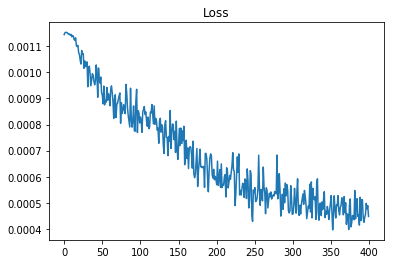

In [8]:
train(400)

In [9]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

print('accuracy: %d %%' % (
    100 * correct / total))

accuracy: 65 %
